In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


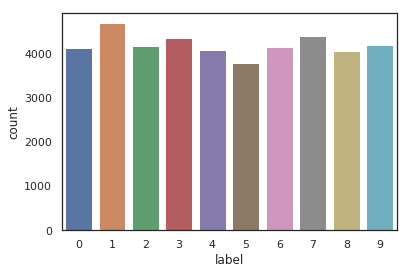

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 
del train 

g = sns.countplot(Y_train)

In [3]:
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Y_train = to_categorical(Y_train, num_classes = 10)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2019)

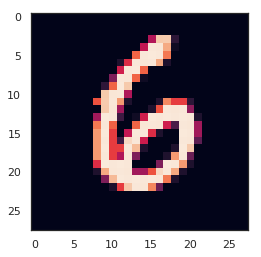

In [4]:
g = plt.imshow(X_train[0][:,:,0])

In [5]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Dropout(0.25))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Dropout(0.25))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
checkpoint = ModelCheckpoint('model.hdf5', monitor='val_acc', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [reduce_lr, early_stopping, checkpoint]

epochs = 10
batch_size = 32

In [7]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)
datagen.fit(X_train)

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1181/1181 [==============================] - 17s 15ms/step - loss: 0.2947 - acc: 0.9082 - val_loss: 0.0519 - val_acc: 0.9852
Epoch 2/10
1181/1181 [==============================] - 12s 11ms/step - loss: 0.1031 - acc: 0.9696 - val_loss: 0.0399 - val_acc: 0.9890
Epoch 3/10
1181/1181 [==============================] - 13s 11ms/step - loss: 0.0871 - acc: 0.9754 - val_loss: 0.0353 - val_acc: 0.9898
Epoch 4/10
1181/1181 [==============================] - 12s 10ms/step - loss: 0.0795 - acc: 0.9782 - val_loss: 0.0586 - val_acc: 0.9833
Epoch 5/10
1181/1181 [==============================] - 12s 10ms/step - loss: 0.0790 - acc: 0.9788 - val_loss: 0.0380 - val_acc: 0.9907
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


In [8]:
#画出模型的损失和预测的精度
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']
    ylim_pad = [0.01, 0.1]

    plt.figure(figsize=(15, 5))
    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
    plt.subplot(121)
    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    
    plt.show()

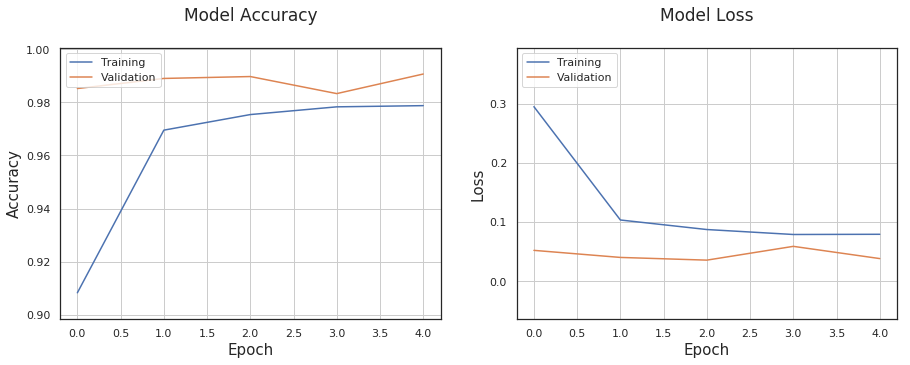

In [9]:
plot_performance(history)

In [10]:
#混淆矩阵
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

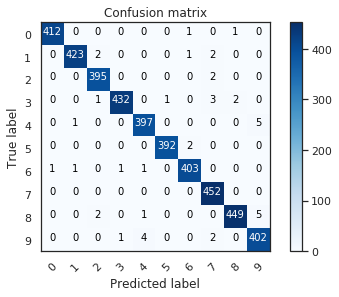

In [11]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [12]:
#展示预测错误的图片  from:https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


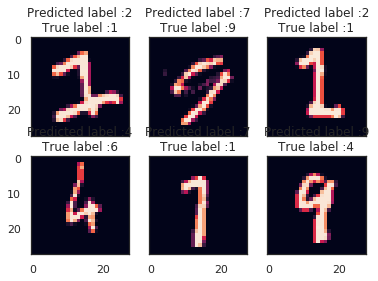

In [13]:
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]   
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]    

# 错误预测图片的可能性
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# 预测标签的概率与真实标签之间的差异
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# 排序
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 取前六个
most_important_errors = sorted_dela_errors[-6:]

# 展示
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [14]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
sub = pd.DataFrame()
sub['ImageId'] = [i for i in range(1,28001)]
sub['Label'] = results
sub.to_csv("sub.csv",index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
